# All PyZX Features

## Contents:
* [Loading and saving circuits](#circuits)
* [Interacting with Quantomatic](#quantomatic)
* [Optimizing ZX-diagrams](#optimization-zx)
* [Extracting and optimizing circuits](#optimization-circuits)
* [Phase Teleportation](#phase-teleportation)

In [58]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction

<a id="circuits"></a>
# Loading and saving circuits
The most straightforward way to load a circuit is to use ``zx.Circuit.load`` which tries to figure out in which file format the circuit is given. The supported file formats are QASM, QC and the Quipper ASCII format. The corresponding loading functions are:
* ``zx.Circuit.from_qasm_file``
* ``zx.Circuit.from_quipper_file``
* ``zx.Circuit.from_qc_file``

In [2]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname)
# Alternatively we could have done:
# circ = zx.Circuit.from_quipper_file(fname)
circ.gates

[NOT(4),
 HAD(4),
 CCZ(c1=0,c2=3,t=4),
 CCZ(c1=2,c2=3,t=4),
 HAD(4),
 CNOT(3,4),
 HAD(4),
 CCZ(c1=1,c2=2,t=4),
 HAD(4),
 CNOT(2,4),
 HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4),
 CNOT(1,4),
 CNOT(0,4)]

As you can see, a circuit is essentially a list of gates (objects of type zx.circuit.Gate). We can draw the circuit using zx.draw():

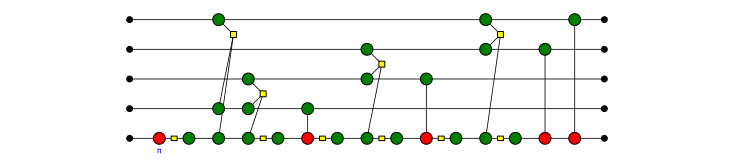

In [6]:
zx.draw_matplotlib(circ, figsize=(10,2), h_edge_draw='box')

The CCZ gates are drawn in [ZH](https://arxiv.org/abs/1805.02175) notation by default. We can get a pure ZX-diagram if we first convert the circuit to basic (i.e. Clifford+T) gates:

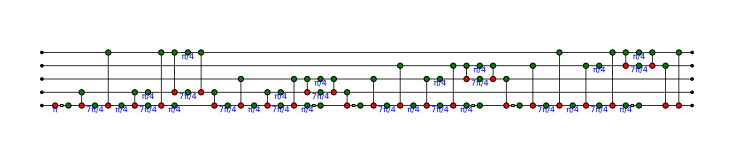

In [7]:
zx.draw_matplotlib(circ.to_basic_gates(), figsize=(10,2), h_edge_draw='box')

Here we've drawn the circuit using the Matplotlib backend, but we can also use the D3 Javascript library to generate a more interactive representation:

In [8]:
zx.draw(circ)

We can ask for simple statistics for this circuit:

In [9]:
print(circ.stats())

Circuit mod5_4_before on 5 qubits with 15 gates.
        28 is the T-count
        11 Cliffords among which 
        4 2-qubit gates and 6 Hadamard gates.
There are 4 gates of a different type


Note that a lot of the circuit is hidden in the mysterious "4 gates of a different type" (which are the CCZ gates). We can write the circuit in terms of basic gates to get more accurate Clifford+T statistics:

In [11]:
print(circ.to_basic_gates().stats())

Circuit mod5_4_before on 5 qubits with 63 gates.
        28 is the T-count
        35 Cliffords among which 
        28 2-qubit gates and 6 Hadamard gates.


A Circuit can be exported into the supported file formats using
    * ``circ.to_qasm``
    * ``circ.to_quipper``
    * ``circ.to_qc``

In [13]:
print(circ.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
x q[4];
h q[4];
ccz q[0], q[3], q[4];
ccz q[2], q[3], q[4];
h q[4];
cx q[3], q[4];
h q[4];
ccz q[1], q[2], q[4];
h q[4];
cx q[2], q[4];
h q[4];
ccz q[0], q[1], q[4];
h q[4];
cx q[1], q[4];
cx q[0], q[4];



In [14]:
print(circ.to_quipper())

Inputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit
QGate["not"](4) with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+3] with nocontrol
QGate["Z"](4) with controls=[+2,+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+1,+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+1] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+1] with nocontrol
QGate["not"](4) with controls=[+0] with nocontrol
Outputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit


In [16]:
print(circ.to_qc())

.v q0 q1 q2 q3 q4

BEGIN
X q4
H q4
Z q0 q3 q4
Z q2 q3 q4
H q4
Tof q3 q4
H q4
Z q1 q2 q4
H q4
Tof q2 q4
H q4
Z q0 q1 q4
H q4
Tof q1 q4
Tof q0 q4
END



<a id="quantomatic"></a>
# Interacting with Quantomatic
PyZX allows easy integration with quantomatic.

First of all, Quantomatic graph files can be imported into PyZX:

In [18]:
fname = os.path.join('..','circuits','2-qubit-unitary.qgraph')
with open(fname, 'r') as f:
    g = zx.Graph.from_json(f.read())
zx.draw(g, labels=True)

PyZX saves the names of the vertices:

In [19]:
print(g.vdata(12,'name'))
print(g.vdata(1,'name'))

b7
v10


Because this graph was originally exported from PyZX, it has automatically remembered what its inputs and outputs are:

In [20]:
g.inputs, g.outputs

([10, 12], [9, 11])

For a graph that originated from Quantomatic we need to tell it what its inputs and outputs are.

This can be done either manually:

    ``g.inputs = list_of_inputs; g.outputs = list_of_outputs``
Or by PyZX trough calling ``g.auto_detect_inputs()``. This function makes all the vertices on the leftmost row inputs, and the vertices on the rightmost row outputs. For example:

In [22]:
g.inputs = []
g.outputs = []
g.auto_detect_inputs()
print(g.inputs, g.outputs)

[12, 10] [9, 11]


We can also call Quantomatic from PyZX. To do this we first need to tell PyZX where the Quantomatic executable can be found:

In [23]:
zx.quantomatic.quantomatic_location = os.path.join('path', 'to', 'Quantomatic.jar')

Now, we can load a PyZX graph into Quantomatic using the following line:

In [24]:
result = zx.quantomatic.edit_graph(g)

This starts Quantomatic with the graph ``g`` loaded. When you are done editing the graph, you simply save the file in Quantomatic, and close it. The result is then loaded and returned.

NOTE1: The Notebook will be blocked until the Quantomatic executable is closed.

NOTE2: Currently this only works with a recent build of Quantomatic that is as of yet only available via the repository, so make sure you are working with an up-to-date branch of Quantomatic.

<a id="optimization-zx"></a>
# Optimizing ZX-diagrams
PyZX contains many functions for optimizing circuits and ZX-diagrams. In this section we will show how these methods work and can be called.

First, let us load a small circuit:

In [27]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("original T-count:", zx.tcount(circ))
zx.draw(circ)

original T-count: 28


The most basic simplification routine for ZX-graphs is ``interior_clifford_simp``. This uses the simplification rules based on spider-fusion, identity removal, pivoting and local complementation until they cannot be applied anymore.

In [29]:
g = circ.to_graph() # We first have to convert the circuit into a ZX-graph
zx.simplify.interior_clifford_simp(g,quiet=False) # if it is not quiet then the amount of reductions in each step is printed
# The following function makes the representation of the graph more compact. 
# It only moves vertices around, and may introduce some identities
# It is recommended to call this function before trying to draw a graph, as otherwise the graph might not be very readable.
g.normalise() 
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

spider_simp: 11. 9. 4. 3. 2.  5 iterations
id_simp: 6.  1 iterations
spider_simp: 3.  1 iterations
pivot_simp: 4.  1 iterations


Optimized T-count: 22


As you can see this routine has decreased the T-count by a bit, but not by a lot.


Part of the reason is that in this circuit there are still a few phaseless nodes 'trapped' in the middle of the circuit. These nodes are however connected to the boundary, so if we unfuse those boundary nodes we can get rid of the interior nodes. This can be done by calling ``zx.simplify.pivot_boundary_simp``. As this function changes the graph, we call ``interior_clifford_simp`` afterwards to do whatever new simplifications have become available.

In [31]:
zx.simplify.pivot_boundary_simp(g, quiet=False)
zx.draw(g)
zx.simplify.interior_clifford_simp(g,quiet=False)
g.normalise()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 22


Though the graph is smaller now, it hasn't decreased the T-count any further in this case.

The method ``clifford_simp`` is a convenience function that calls ``interior_clifford_simp`` and ``pivot_boundary_simp`` until no further simplifications are found. It is recommended that you call ``clifford_simp`` instead of the other functions.
In order to further reduce the T-count we have to start using more advanced techniques. Namely the process of *gadgetization*:

In [32]:
zx.simplify.pivot_gadget_simp(g, quiet=False)
zx.draw(g)
print("T-count:", zx.tcount(g))

pivot_gadget_simp: 5. 2. 3. 2. 2. 1.  6 iterations


T-count: 22


This method combines all T-like phases with a phaseless spider to turn it into a *phase gadget*. In the previous diagram those are the spider pairs floating above the rest of the diagram, which we refer to as its *skeleton*. As you can see, the T-count has not actually been reduced by doing just these pivots, but now the graph has a completely different structure then before, so lets see what happens if we apply ``clifford_simp`` again:

In [39]:
zx.simplify.clifford_simp(g, quiet=False)
g.normalise()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

id_simp: 1.  1 iterations


Optimized T-count: 8


That has reduced the T-count from 22 down to 18!

But we are in fact not done yet. If you look closely at the graph above you will see that a few of the gadgets have exactly the same set of neighbours. Whenever this happens, these phase gadgets can be fused into a single phase gadget by adding the phases together. This procedure is done by ``gadget_simp``:

In [40]:
zx.simplify.gadget_simp(g, quiet=False)
g.normalise()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Optimized T-count: 8


The T-count has now more than halved! Note that the previous best-known T-count for this circuit was 16, so this is a big improvement.

There is not much we can do now. We do one final round of ``clifford_simp`` to make the graph a bit smaller.

In [41]:
zx.simplify.clifford_simp(g, quiet=False)
g.normalise()
zx.draw(g)

id_simp: 1.  1 iterations


Since it is quite a bit of effort to do all these steps manually, they have been combined into the function ``full_reduce``. This procedure does the following steps:

 1. Run ``clifford_simp``.
 2. Gadgetize the diagram using ``pivot_gadget_simp``.
 4. Run ``clifford_simp``.
 5. Run ``gadget_simp``. If it finds simplifications go back to step 1, otherwise halt.
 
To demonstrate:

In [43]:
g = circ.to_basic_gates().to_graph()
zx.simplify.full_reduce(g,quiet=False)
g.normalise()
zx.draw(g)

spider_simp: 11. 9. 4. 3. 2.  5 iterations
id_simp: 6.  1 iterations
spider_simp: 3.  1 iterations
pivot_simp: 4.  1 iterations
pivot_gadget_simp: 12. 4. 2. 1. 1.  5 iterations
id_simp: 8.  1 iterations
spider_simp: 1. 1. 1. 1.  4 iterations
gadget_simp: 4.  1 iterations
lcomp_simp: 4. 4.  2 iterations


The next step is to turn this graph back into a circuit

<a id="optimization-circuits"></a>
# Extracting and optimizing circuits

For extracting circuits out of ZX-graphs there is only a single method in PyZX that you have to call: ``zx.extract.streaming_extract``. This method should always work *when dealing with graphs produced by ``full_reduce``.* There is no guarantee that it can extract circuits from arbitrary ZX-diagrams.

Let's see what this method does when applied to the circuit from the previous section:

In [45]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)

g = circ.to_graph()
zx.simplify.full_reduce(g,quiet=True)
g.normalise()
print("The optimized ZX-diagram:")
zx.draw(g)

new_circ = zx.extract.streaming_extract(g)
print("The extracted circuit:")
zx.draw(new_circ)

The original circuit:


The optimized ZX-diagram:


The extracted circuit:


Explaining how ``streaming_extract`` works is out of scope for this notebook for now. If you want to know more you can check out the paper [Graph-theoretic Simplification of Quantum Circuits with the ZX-calculus](https://arxiv.org/abs/1902.03178).

As you can see, the extracted circuit looks quite different from the original circuit, so how can we be sure that they actually represent the same unitary? PyZX allows you to convert ZX-diagrams into the tensors they represent using numpy. In this way we can directly compare the unitaries and see that they are equal:

In [46]:
# This method checks whether the two given ZX-graphs or circuits have the same tensor representation up to some nonzero scalar
zx.compare_tensors(circ, new_circ)

True

This method uses ``zx.tensorfy`` under the hood to turn the circuits into tensors. This method is not optimized for memory usage, so it will run out of memory quite quickly (sometimes even for circuits with 9 or 10 qubits). It is only usable for testing small circuits and ZX-diagrams.

For larger circuits PyZX also offers a different method to check whether two circuits are equal:

In [47]:
circ.verify_equality(new_circ)

True

This method takes the composition of the first circuit with the adjoint of the second and simplifies the resulting circuit with ``full_reduce``. If it succeeds, it returns ``True``, if it does not it returns ``False``. This means that if this method succeeds, that is very likely that the 2 circuits are equal (it would be very unlikely that some bug in the rewriting engine would cancel out in exactly the right way to be able to reduce the circuit to the identity). However, if it returns ``False`` it might simply mean that the rewrite engine is not powerful enough to verify the equality of the two circuits.

``streaming_extract`` does not care about extracting a circuit that is in any way optimal. The amount of 2-qubit gates will therefore often be much higher than it needs to be. If you look at the end of the extracted circuit above you also see that it has some sequences of hadamards in a row that should be cancelled. PyZX offers a circuit optimization method that does this kind of hadamard and 2-qubit gate reduction:

In [50]:
print(new_circ.to_basic_gates().stats())
optimized_circ = zx.optimize.basic_optimization(new_circ.to_basic_gates())
print(optimized_circ.stats())
zx.draw(optimized_circ)

Circuit  on 5 qubits with 45 gates.
        8 is the T-count
        37 Cliffords among which 
        24 2-qubit gates and 10 Hadamard gates.
Circuit  on 5 qubits with 34 gates.
        8 is the T-count
        26 Cliffords among which 
        24 2-qubit gates and 2 Hadamard gates.


``basic_optimization`` commutes gates past Hadamards in order to find matching CNOT, CZ and Hadamard gates that can be cancelled. Depending on the circuit it can find significant reductions in the amount of Hadamard gates, which is useful for the next optimization routine.

As you can see, the optimized circuit only contains 2 Hadamard gates, and in fact the leftmost Hadamard gate could be commuted past the CNOTs and CZs to its left so that the entire interior of the circuit is free of Hadamards. Such a Hadamard-free circuit is called a *phase polynomial* circuit, and there are specific techniques for optimizing these types of circuits. PyZX offers a method that finds phase polynomial sub-circuits and runs an optimization routine on them:

In [51]:
final_circ = zx.optimize.phase_block_optimize(optimized_circ)
final_circ = zx.optimize.basic_optimization(final_circ) # We call this again, as it does some extra processing
print(final_circ.stats())
zx.draw(final_circ)

Circuit  on 5 qubits with 27 gates.
        8 is the T-count
        19 Cliffords among which 
        14 2-qubit gates and 2 Hadamard gates.


Let's check once more that this circuit is still equal to the original circuit:

In [52]:
zx.compare_tensors(circ, final_circ)

True

And finally lets output this circuit in a format that is usable in other software:

In [53]:
print(final_circ.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
s q[0];
cz q[0], q[1];
z q[1];
cz q[1], q[2];
s q[2];
cx q[3], q[2];
h q[4];
rz(0.75*pi) q[2];
cx q[3], q[0];
cx q[4], q[2];
rz(0.75*pi) q[0];
t q[2];
cx q[1], q[2];
cx q[3], q[2];
cx q[4], q[0];
t q[0];
cx q[1], q[0];
t q[2];
cx q[3], q[0];
cx q[4], q[2];
t q[0];
t q[2];
cx q[1], q[2];
cx q[4], q[0];
h q[4];
t q[0];
cx q[1], q[0];



<a id="phase-teleportation"></a>
# Phase teleportation

The above procedure of simplifying a diagram, and extracting a new circuit directly from it worked quite well in the example given above, but unfortunately in other cases it can actually *increase* the total gate-count (although it never increases the amount of T-gates).

To get around this issue PyZX offers the *phase teleportation* routine. This uses the diagrammatic simplification only as information to inform when phase gates can be combined in the original circuit, but otherwise it leaves the circuit intact. The details can be found in [Reducing T-count with the ZX-calculus](https://arxiv.org/abs/1903.10477).

In [56]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)
g = zx.simplify.teleport_reduce(circ.to_graph(),quiet=True)
print("Circuit after phase teleportation:")
zx.draw(g)

The original circuit:


Circuit after phase teleportation:


As you can see the circuit is exactly the same, except that it has less phase gates. Let's verify that it is indeed still the same circuit:

In [57]:
zx.compare_tensors(circ, g)

True